#### 1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)


In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,  mean_squared_error, precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("C:/Users/yana/2/churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], test_size=0.3, random_state=0)

In [4]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [5]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [6]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)), 
        ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))


feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [17]:
models = [LogisticRegression(random_state = 42), RandomForestClassifier(max_depth=5), GradientBoostingClassifier(max_depth=5,learning_rate=0.03)]

#### 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

In [18]:
preds = []
thresh = []
for i in models:
    pipeline = Pipeline([
        ('features',feats),
        ('classifier', i),
    ])

    #запустим кросс-валидацию
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=6, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print('CV score is {}+-{}'.format(cv_score, cv_score_std))

    #обучим пайплайн на всем тренировочном датасете
    pipeline.fit(X_train, y_train)
    y_score = pipeline.predict_proba(X_test)[:, 1]
    preds.append(y_score)
    b=1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    ix = np.argmax(fscore)
    thresh.append(thresholds[ix])
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc_auc=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix], roc_auc_score(y_test, y_score)))  
    
    

CV score is 0.7611582818119528+-0.019196211284232562
Best Threshold=0.259753, F-Score=0.512, Precision=0.440, Recall=0.612, Roc_auc=0.772
CV score is 0.8367428601705521+-0.012409981597910676
Best Threshold=0.289114, F-Score=0.630, Precision=0.656, Recall=0.605, Roc_auc=0.859
CV score is 0.8590481784207453+-0.009274999852087072
Best Threshold=0.303306, F-Score=0.649, Precision=0.632, Recall=0.667, Roc_auc=0.876


Лучшая модель в данном случае - GradientBoostingClassifier. Наиболее подходящая метрика - F-score, т.к. датасет несбалансированный, а эта метрика "штрафуется", если будет плохой результат по precision или по recall

#### 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

In [19]:
preds = preds[2]
thresholds = thresh[2]

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
font = {'size' : 15}

plt.rc('font', **font)

Confusion matrix, without normalization
[[2138  241]
 [ 208  413]]


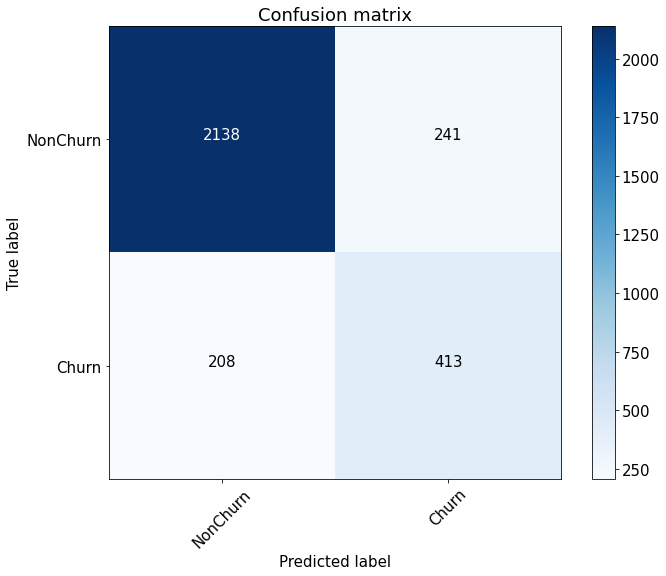

In [21]:
cnf_matrix = confusion_matrix(y_test, preds>thresholds)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [22]:
add_summ = cnf_matrix[1,1]*2 - np.sum(cnf_matrix[:,1])*1
print('дополнительный доход(если с "-" затраты): ', add_summ )

дополнительный доход(если с "-" затраты):  172


Модель эффективна, т.к. если мы тратим по 1 р на удержание 413(TP) и 241(FP) клиентов, то при удержании 413 клиентов, которые действительно собрались уйти, мы получим доп доход 172 р. 

#### 4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [23]:
pipeline = Pipeline([
        ('features',feats),
        ('classifier', GradientBoostingClassifier()),
    ])

In [61]:
from sklearn.model_selection import GridSearchCV

params={'classifier__max_features':[0.5, 0.7, 1],
        'classifier__min_samples_leaf':[1, 2, 3],
        'classifier__max_depth':[4, 5, 6, 8], 
        'classifier__learning_rate': [0.03, 0.05, 0.1], 
        'classifier__n_estimators': [50, 100, 150]
        }

grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=5,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__learning_rate': 0.03,
 'classifier__max_depth': 8,
 'classifier__max_features': 0.5,
 'classifier__min_samples_leaf': 1,
 'classifier__n_estimators': 100}

In [24]:
pipeline = Pipeline([
        ('features',feats),
        ('classifier', GradientBoostingClassifier(learning_rate = 0.03, max_depth = 8, 
                                                  max_features=0.5, min_samples_leaf=1, n_estimators=100)),
    ])
pipeline.fit(X_train, y_train)
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc_auc=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix], roc_auc_score(y_test, y_score)))  

Best Threshold=0.334007, F-Score=0.655, Precision=0.656, Recall=0.654, Roc_auc=0.876


#### 5. (опционально) Еще раз провести оценку экономической эффективности

In [25]:
cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
add_summ = cnf_matrix[1,1]*2 - np.sum(cnf_matrix[:,1])*1
print('дополнительный доход(если с "-" затраты): ', add_summ )

дополнительный доход(если с "-" затраты):  192


In [26]:
max_revenue = 0
best_t = 0
for t in thresholds:
    cnf_matrix = confusion_matrix(y_test, preds>t)
    add_summ = cnf_matrix[1,1]*2 - np.sum(cnf_matrix[:,1])*1
    if add_summ > max_revenue:
        max_revenue = add_summ
        best_t = t
print(f'Максимальный доход: {max_revenue} достигнут при пороге {best_t}')
    

Максимальный доход: 221 достигнут при пороге 0.5104800478418201


После подбора параметров модели результат улучшился (F-score увеличился), экономическая выгода также возросла. Но лучший F-score не является оптимальным для модели с точки зрения экономики: выгоднее увеличить порог отнесения клиентов к оттоку. 